In [1]:
import scipy.io as spio
import numpy as np

X = spio.loadmat(file_name='../data/bci-sample-data/x.mat')
Y = spio.loadmat(file_name='../data/bci-sample-data/y.mat')

Data = X['Intensification_Data']
SType = Y['Intensification_SType'].mean(axis=1)

print(Data.shape, SType.shape, Data.dtype, SType.dtype)

# 30 % total data test
# 70 % total data train+valid
length = int(Data.shape[0] * 0.30)
print(length)

TrainDataAll = Data[:-length]
TestData = Data[-length:]

print(TrainDataAll.shape, TestData.shape)

# 30% total train data is valid
# 70% total trainALl is training
length2 = int(TrainDataAll.shape[0] * 0.30)
print(length2)

TrainData = TrainDataAll[:-length2]
ValidData = TrainDataAll[-length2:]

print(TrainData.shape, ValidData.shape)

# Normalizing input data
def normalize(inputs):
    return (inputs - inputs.mean(axis=0)[None,:,:]) / inputs.std(axis=0)[None,:,:]

# onehot vectorizing output labels
def one_hot(labels, n_class):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

# get minibatches for learning
def get_batches(X, y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

# Standardize/normalize train and test
X_train_norm = normalize(inputs=TrainData)
X_valid_norm = normalize(inputs=ValidData)
X_test_norm = normalize(inputs=TestData)

print(X_train_norm.shape, X_train_norm.dtype, 
X_valid_norm.shape, X_valid_norm.dtype,
X_test_norm.shape, X_test_norm.dtype)

LabelsAll = SType[:]
TrainLabelsAll = SType[:-length]
TestLabels = SType[-length:]

print(LabelsAll.shape, TrainLabelsAll.shape, TestLabels.shape)

TrainLabels = TrainLabelsAll[:-length2]
ValidLabels = TrainLabelsAll[-length2:]

print(TrainLabels.shape, ValidLabels.shape)

Y_train = np.array(TrainLabels, dtype=int)
Y_valid = np.array(ValidLabels, dtype=int)
Y_test = np.array(TestLabels, dtype=int)

print(Y_train.shape, Y_train.dtype, 
Y_test.shape, Y_test.dtype,
Y_valid.shape, Y_valid.dtype)

### Hyperparameters

# CNN hyper parameters
# Input data
batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial

# Output labels
n_classes = int(LabelsAll.max() + 1)

# Tweekable parameters
learning_rate = 0.001 #1e-3
epochs = 10 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

Y_train_onehot = one_hot(labels=Y_train, n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid, n_class=n_classes)
Y_test_onehot = one_hot(labels=Y_test, n_class=n_classes)

print(Y_train_onehot.shape, Y_valid_onehot.shape, Y_test_onehot.shape,
 X_train_norm.shape, X_valid_norm.shape, X_test_norm.shape)

# GPUs availability or CPU

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

#  No graphs is needed on tensorflow
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')

(6480, 192, 64) (6480,) float64 float64
1944
(4536, 192, 64) (1944, 192, 64)
1360
(3176, 192, 64) (1360, 192, 64)
(3176, 2) (1360, 2) (1944, 2) (3176, 192, 64) (1360, 192, 64) (1944, 192, 64)
TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [2]:
# Construct the LSTM inputs and LSTM cells
#  This functions very similar to embedding
print(inputs_.shape)
lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
print(lstm_in.shape)
lstm_in = tf.reshape(lstm_in, [-1, 64]) # Now (seq_len*N, n_channels)
print(lstm_in.shape)

# To cells
lstm_size = 64*3 # 3 times the amount of input channels
print(lstm_size)
lstm_layers = 1        # Number of layers
lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
print(lstm_in.shape)

# Open up the tensor into a list of input seq_len pieces
lstm_in = tf.split(lstm_in, 192, 0)
print(len(lstm_in))

(?, 192, 64)
(192, ?, 64)
(?, 64)
192
(?, 192)
192


In [3]:
# Add LSTM layers
# lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
lstm = tf.nn.rnn_cell.BasicLSTMCell(lstm_size)
print(lstm)
# drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
drop = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
print(drop)
# cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
cell = tf.nn.rnn_cell.MultiRNNCell([drop] * lstm_layers)
print(cell)
initial_state = cell.zero_state(batch_size, tf.float32)
print(initial_state)

(LSTMStateTuple(c=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros:0' shape=(31, 192) dtype=float32>, h=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros_1:0' shape=(31, 192) dtype=float32>),)


In [4]:
# Reuse should be activated
#  NOTE: should be run ONCE
# Remember the inputs are usually embedded input or texts
# outputs, final_state = tf.contrib.rnn.static_rnn(cell=cell, inputs=lstm_in, dtype=tf.float32, 
#                                                  initial_state = initial_state)
outputs, final_state = tf.nn.static_rnn(cell=cell, inputs=lstm_in, dtype=tf.float32,
                                        initial_state = initial_state)
# outputs, final_state = tf.nn.dynamic_rnn(cell, lstm_in, dtype=tf.float32, 
#                                          initial_state=initial_state)# print(outputs, final_state)

In [5]:
# We only need the last output tensor to pass into a classifier
logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
print(logits, outputs[-1])

Tensor("logits/BiasAdd:0", shape=(31, 2), dtype=float32) Tensor("rnn/rnn/multi_rnn_cell/cell_0_191/dropout/mul:0", shape=(31, 192), dtype=float32)


In [6]:
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [7]:
### Train the network
# Plotting the acc and loss curve
train_acc = []
train_loss = []

valid_acc = []
valid_loss = []

with tf.Session() as sess:
    # initalize session global variables just in the case they are initialized.
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary
            feed = {inputs_:x, labels_:y, keep_prob_: keep_prob, initial_state:state, 
                    learning_rate_:learning_rate}
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], feed_dict = feed)
            
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################################ Validation
            # Initialize 
            state_v = sess.run(cell.zero_state(batch_size, tf.float32))
            loss_v_batch, acc_v_batch = [], []

            # Loop over batches
            for x_v, y_v in get_batches(X_valid_norm, Y_valid_onehot, batch_size):

                # Feed dictionary
                feed = {inputs_:x_v, labels_:y_v, keep_prob_: 1.0, initial_state:state_v}
                loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                
                acc_v_batch.append(acc_v)
                loss_v_batch.append(loss_v)
                
            valid_acc.append(np.mean(acc_v_batch))
            valid_loss.append(np.mean(loss_v_batch))
            
            # Print info
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Train loss: {:6f}".format(loss),
                  "Valid loss: {:.6f}".format(np.mean(valid_loss)),
                  "Train acc: {:6f}".format(acc),
                  "Valid acc: {:.6f}".format(np.mean(valid_acc)))
            
    ################################ Test
    # Initialize 
    state = sess.run(initial_state)
    acc_batch, loss_batch = [], []

    # Loop over batches
    for x, y in get_batches(X_test_norm, Y_test_onehot, batch_size):

        # Feed dictionary
        feed = {inputs_:x, labels_:y, keep_prob_:1.0, initial_state:state}
        loss, state, acc = sess.run([cost, final_state, accuracy], feed_dict = feed)

        acc_batch.append(acc)
        loss_batch.append(loss)

    # Print info
    print("Epoch: {}/{}".format(e+1, epochs),
          "Test loss: {:6f}".format(np.mean(loss_batch)),
          "Test acc: {:6f}".format(np.mean(acc_batch)))

Epoch: 1/10 Train loss: 0.827617 Valid loss: 0.726528 Train acc: 0.483871 Valid acc: 0.522881
Epoch: 1/10 Train loss: 0.687277 Valid loss: 0.737945 Train acc: 0.806452 Valid acc: 0.525131
Epoch: 1/10 Train loss: 0.604286 Valid loss: 0.738455 Train acc: 0.806452 Valid acc: 0.529382
Epoch: 1/10 Train loss: 0.498939 Valid loss: 0.735141 Train acc: 0.838710 Valid acc: 0.534884
Epoch: 1/10 Train loss: 0.553742 Valid loss: 0.729814 Train acc: 0.774194 Valid acc: 0.540735
Epoch: 1/10 Train loss: 0.541358 Valid loss: 0.718467 Train acc: 0.741935 Valid acc: 0.553763
Epoch: 1/10 Train loss: 0.607455 Valid loss: 0.705428 Train acc: 0.677419 Valid acc: 0.571536
Epoch: 1/10 Train loss: 0.546595 Valid loss: 0.693182 Train acc: 0.806452 Valid acc: 0.588428
Epoch: 1/10 Train loss: 0.446741 Valid loss: 0.682631 Train acc: 0.870968 Valid acc: 0.602567
Epoch: 1/10 Train loss: 0.549363 Valid loss: 0.673489 Train acc: 0.838710 Valid acc: 0.614404
Epoch: 1/10 Train loss: 0.490351 Valid loss: 0.665409 Train 

Epoch: 1/10 Train loss: 0.519617 Valid loss: 0.507968 Train acc: 0.870968 Valid acc: 0.793007
Epoch: 1/10 Train loss: 0.501998 Valid loss: 0.507481 Train acc: 0.838710 Valid acc: 0.793448
Epoch: 1/10 Train loss: 0.491107 Valid loss: 0.507002 Train acc: 0.838710 Valid acc: 0.793880
Epoch: 1/10 Train loss: 0.415951 Valid loss: 0.506527 Train acc: 0.838710 Valid acc: 0.794302
Epoch: 1/10 Train loss: 0.566238 Valid loss: 0.506060 Train acc: 0.806452 Valid acc: 0.794715
Epoch: 1/10 Train loss: 0.377064 Valid loss: 0.505599 Train acc: 0.870968 Valid acc: 0.795119
Epoch: 1/10 Train loss: 0.468899 Valid loss: 0.505158 Train acc: 0.806452 Valid acc: 0.795515
Epoch: 1/10 Train loss: 0.529925 Valid loss: 0.504718 Train acc: 0.774194 Valid acc: 0.795902
Epoch: 1/10 Train loss: 0.560942 Valid loss: 0.504282 Train acc: 0.806452 Valid acc: 0.796282
Epoch: 1/10 Train loss: 0.407801 Valid loss: 0.503850 Train acc: 0.838710 Valid acc: 0.796653
Epoch: 1/10 Train loss: 0.523152 Valid loss: 0.503420 Train 

Epoch: 2/10 Train loss: 0.344825 Valid loss: 0.484657 Train acc: 0.870968 Valid acc: 0.813021
Epoch: 2/10 Train loss: 0.406998 Valid loss: 0.484488 Train acc: 0.838710 Valid acc: 0.813132
Epoch: 2/10 Train loss: 0.652556 Valid loss: 0.484325 Train acc: 0.806452 Valid acc: 0.813245
Epoch: 2/10 Train loss: 0.487954 Valid loss: 0.484169 Train acc: 0.838710 Valid acc: 0.813358
Epoch: 2/10 Train loss: 0.494496 Valid loss: 0.484018 Train acc: 0.806452 Valid acc: 0.813469
Epoch: 2/10 Train loss: 0.424588 Valid loss: 0.483870 Train acc: 0.870968 Valid acc: 0.813578
Epoch: 2/10 Train loss: 0.433933 Valid loss: 0.483723 Train acc: 0.838710 Valid acc: 0.813687
Epoch: 2/10 Train loss: 0.641424 Valid loss: 0.483576 Train acc: 0.806452 Valid acc: 0.813794
Epoch: 2/10 Train loss: 0.487300 Valid loss: 0.483430 Train acc: 0.838710 Valid acc: 0.813897
Epoch: 2/10 Train loss: 0.490627 Valid loss: 0.483285 Train acc: 0.838710 Valid acc: 0.813998
Epoch: 2/10 Train loss: 0.518955 Valid loss: 0.483140 Train 

Epoch: 3/10 Train loss: 0.492728 Valid loss: 0.476043 Train acc: 0.806452 Valid acc: 0.819734
Epoch: 3/10 Train loss: 0.416953 Valid loss: 0.475981 Train acc: 0.870968 Valid acc: 0.819783
Epoch: 3/10 Train loss: 0.469265 Valid loss: 0.475923 Train acc: 0.806452 Valid acc: 0.819831
Epoch: 3/10 Train loss: 0.365508 Valid loss: 0.475871 Train acc: 0.870968 Valid acc: 0.819879
Epoch: 3/10 Train loss: 0.551520 Valid loss: 0.475822 Train acc: 0.806452 Valid acc: 0.819927
Epoch: 3/10 Train loss: 0.520958 Valid loss: 0.475773 Train acc: 0.838710 Valid acc: 0.819972
Epoch: 3/10 Train loss: 0.478907 Valid loss: 0.475725 Train acc: 0.806452 Valid acc: 0.820016
Epoch: 3/10 Train loss: 0.401341 Valid loss: 0.475675 Train acc: 0.870968 Valid acc: 0.820057
Epoch: 3/10 Train loss: 0.445306 Valid loss: 0.475622 Train acc: 0.838710 Valid acc: 0.820098
Epoch: 3/10 Train loss: 0.585675 Valid loss: 0.475564 Train acc: 0.774194 Valid acc: 0.820138
Epoch: 3/10 Train loss: 0.385871 Valid loss: 0.475501 Train 

Epoch: 4/10 Train loss: 0.474569 Valid loss: 0.472050 Train acc: 0.806452 Valid acc: 0.822786
Epoch: 4/10 Train loss: 0.394407 Valid loss: 0.472019 Train acc: 0.870968 Valid acc: 0.822812
Epoch: 4/10 Train loss: 0.415481 Valid loss: 0.471992 Train acc: 0.870968 Valid acc: 0.822837
Epoch: 4/10 Train loss: 0.420582 Valid loss: 0.471968 Train acc: 0.838710 Valid acc: 0.822861
Epoch: 4/10 Train loss: 0.480905 Valid loss: 0.471946 Train acc: 0.806452 Valid acc: 0.822884
Epoch: 4/10 Train loss: 0.436803 Valid loss: 0.471926 Train acc: 0.838710 Valid acc: 0.822908
Epoch: 4/10 Train loss: 0.465220 Valid loss: 0.471906 Train acc: 0.806452 Valid acc: 0.822931
Epoch: 4/10 Train loss: 0.480278 Valid loss: 0.471886 Train acc: 0.806452 Valid acc: 0.822954
Epoch: 4/10 Train loss: 0.386604 Valid loss: 0.471867 Train acc: 0.838710 Valid acc: 0.822977
Epoch: 4/10 Train loss: 0.401165 Valid loss: 0.471850 Train acc: 0.838710 Valid acc: 0.822999
Epoch: 4/10 Train loss: 0.530114 Valid loss: 0.471834 Train 

Epoch: 5/10 Train loss: 0.435574 Valid loss: 0.471182 Train acc: 0.838710 Valid acc: 0.823953
Epoch: 5/10 Train loss: 0.429192 Valid loss: 0.471160 Train acc: 0.838710 Valid acc: 0.823974
Epoch: 5/10 Train loss: 0.487012 Valid loss: 0.471137 Train acc: 0.806452 Valid acc: 0.823995
Epoch: 5/10 Train loss: 0.457391 Valid loss: 0.471112 Train acc: 0.838710 Valid acc: 0.824017
Epoch: 5/10 Train loss: 0.402340 Valid loss: 0.471087 Train acc: 0.838710 Valid acc: 0.824038
Epoch: 5/10 Train loss: 0.414422 Valid loss: 0.471063 Train acc: 0.838710 Valid acc: 0.824059
Epoch: 5/10 Train loss: 0.506440 Valid loss: 0.471040 Train acc: 0.774194 Valid acc: 0.824080
Epoch: 5/10 Train loss: 0.462596 Valid loss: 0.471018 Train acc: 0.838710 Valid acc: 0.824101
Epoch: 5/10 Train loss: 0.407343 Valid loss: 0.470996 Train acc: 0.870968 Valid acc: 0.824122
Epoch: 5/10 Train loss: 0.439033 Valid loss: 0.470976 Train acc: 0.838710 Valid acc: 0.824143
Epoch: 5/10 Train loss: 0.434937 Valid loss: 0.470955 Train 

Epoch: 6/10 Train loss: 0.401031 Valid loss: 0.470313 Train acc: 0.838710 Valid acc: 0.824904
Epoch: 6/10 Train loss: 0.360156 Valid loss: 0.470303 Train acc: 0.870968 Valid acc: 0.824918
Epoch: 6/10 Train loss: 0.463954 Valid loss: 0.470294 Train acc: 0.838710 Valid acc: 0.824931
Epoch: 6/10 Train loss: 0.418129 Valid loss: 0.470287 Train acc: 0.838710 Valid acc: 0.824944
Epoch: 6/10 Train loss: 0.430666 Valid loss: 0.470280 Train acc: 0.838710 Valid acc: 0.824957
Epoch: 6/10 Train loss: 0.450953 Valid loss: 0.470275 Train acc: 0.838710 Valid acc: 0.824969
Epoch: 6/10 Train loss: 0.311446 Valid loss: 0.470274 Train acc: 0.903226 Valid acc: 0.824982
Epoch: 6/10 Train loss: 0.413196 Valid loss: 0.470274 Train acc: 0.838710 Valid acc: 0.824994
Epoch: 6/10 Train loss: 0.405104 Valid loss: 0.470277 Train acc: 0.838710 Valid acc: 0.825002
Epoch: 6/10 Train loss: 0.468452 Valid loss: 0.470281 Train acc: 0.806452 Valid acc: 0.825006
Epoch: 6/10 Train loss: 0.477867 Valid loss: 0.470288 Train 

Epoch: 7/10 Train loss: 0.429525 Valid loss: 0.470702 Train acc: 0.806452 Valid acc: 0.824796
Epoch: 7/10 Train loss: 0.358115 Valid loss: 0.470721 Train acc: 0.870968 Valid acc: 0.824790
Epoch: 7/10 Train loss: 0.432573 Valid loss: 0.470739 Train acc: 0.838710 Valid acc: 0.824784
Epoch: 7/10 Train loss: 0.423325 Valid loss: 0.470755 Train acc: 0.838710 Valid acc: 0.824778
Epoch: 7/10 Train loss: 0.433831 Valid loss: 0.470768 Train acc: 0.806452 Valid acc: 0.824775
Epoch: 7/10 Train loss: 0.445148 Valid loss: 0.470777 Train acc: 0.838710 Valid acc: 0.824773
Epoch: 7/10 Train loss: 0.439160 Valid loss: 0.470782 Train acc: 0.838710 Valid acc: 0.824774
Epoch: 7/10 Train loss: 0.483646 Valid loss: 0.470785 Train acc: 0.806452 Valid acc: 0.824777
Epoch: 7/10 Train loss: 0.377348 Valid loss: 0.470785 Train acc: 0.838710 Valid acc: 0.824780
Epoch: 7/10 Train loss: 0.433311 Valid loss: 0.470786 Train acc: 0.806452 Valid acc: 0.824782
Epoch: 7/10 Train loss: 0.428404 Valid loss: 0.470787 Train 

Epoch: 7/10 Train loss: 0.490247 Valid loss: 0.471185 Train acc: 0.806452 Valid acc: 0.825204
Epoch: 7/10 Train loss: 0.352543 Valid loss: 0.471188 Train acc: 0.870968 Valid acc: 0.825203
Epoch: 7/10 Train loss: 0.435715 Valid loss: 0.471192 Train acc: 0.838710 Valid acc: 0.825200
Epoch: 7/10 Train loss: 0.422804 Valid loss: 0.471198 Train acc: 0.838710 Valid acc: 0.825195
Epoch: 7/10 Train loss: 0.440852 Valid loss: 0.471207 Train acc: 0.838710 Valid acc: 0.825188
Epoch: 7/10 Train loss: 0.382755 Valid loss: 0.471220 Train acc: 0.838710 Valid acc: 0.825181
Epoch: 7/10 Train loss: 0.449951 Valid loss: 0.471236 Train acc: 0.806452 Valid acc: 0.825170
Epoch: 7/10 Train loss: 0.411879 Valid loss: 0.471258 Train acc: 0.838710 Valid acc: 0.825156
Epoch: 7/10 Train loss: 0.457872 Valid loss: 0.471285 Train acc: 0.838710 Valid acc: 0.825141
Epoch: 7/10 Train loss: 0.535306 Valid loss: 0.471310 Train acc: 0.806452 Valid acc: 0.825126
Epoch: 8/10 Train loss: 0.396562 Valid loss: 0.471334 Train 

Epoch: 8/10 Train loss: 0.386702 Valid loss: 0.472014 Train acc: 0.838710 Valid acc: 0.824969
Epoch: 8/10 Train loss: 0.337577 Valid loss: 0.472011 Train acc: 0.870968 Valid acc: 0.824971
Epoch: 8/10 Train loss: 0.415122 Valid loss: 0.472010 Train acc: 0.838710 Valid acc: 0.824972
Epoch: 8/10 Train loss: 0.520452 Valid loss: 0.472010 Train acc: 0.806452 Valid acc: 0.824971
Epoch: 8/10 Train loss: 0.392090 Valid loss: 0.472010 Train acc: 0.903226 Valid acc: 0.824969
Epoch: 8/10 Train loss: 0.445138 Valid loss: 0.472012 Train acc: 0.838710 Valid acc: 0.824967
Epoch: 8/10 Train loss: 0.422862 Valid loss: 0.472014 Train acc: 0.838710 Valid acc: 0.824964
Epoch: 8/10 Train loss: 0.350584 Valid loss: 0.472015 Train acc: 0.870968 Valid acc: 0.824962
Epoch: 8/10 Train loss: 0.360349 Valid loss: 0.472018 Train acc: 0.870968 Valid acc: 0.824959
Epoch: 8/10 Train loss: 0.365450 Valid loss: 0.472023 Train acc: 0.838710 Valid acc: 0.824955
Epoch: 8/10 Train loss: 0.428517 Valid loss: 0.472029 Train 

Epoch: 9/10 Train loss: 0.478030 Valid loss: 0.474590 Train acc: 0.806452 Valid acc: 0.823701
Epoch: 9/10 Train loss: 0.401711 Valid loss: 0.474588 Train acc: 0.838710 Valid acc: 0.823705
Epoch: 9/10 Train loss: 0.494968 Valid loss: 0.474585 Train acc: 0.806452 Valid acc: 0.823708
Epoch: 9/10 Train loss: 0.376997 Valid loss: 0.474582 Train acc: 0.870968 Valid acc: 0.823712
Epoch: 9/10 Train loss: 0.338998 Valid loss: 0.474578 Train acc: 0.838710 Valid acc: 0.823715
Epoch: 9/10 Train loss: 0.500331 Valid loss: 0.474575 Train acc: 0.806452 Valid acc: 0.823719
Epoch: 9/10 Train loss: 0.342185 Valid loss: 0.474571 Train acc: 0.870968 Valid acc: 0.823722
Epoch: 9/10 Train loss: 0.387138 Valid loss: 0.474568 Train acc: 0.870968 Valid acc: 0.823725
Epoch: 9/10 Train loss: 0.294223 Valid loss: 0.474566 Train acc: 0.870968 Valid acc: 0.823729
Epoch: 9/10 Train loss: 0.550316 Valid loss: 0.474563 Train acc: 0.806452 Valid acc: 0.823731
Epoch: 9/10 Train loss: 0.385846 Valid loss: 0.474560 Train 

Epoch: 10/10 Train loss: 0.370121 Valid loss: 0.476002 Train acc: 0.870968 Valid acc: 0.823472
Epoch: 10/10 Train loss: 0.511260 Valid loss: 0.475996 Train acc: 0.741935 Valid acc: 0.823477
Epoch: 10/10 Train loss: 0.383046 Valid loss: 0.475990 Train acc: 0.838710 Valid acc: 0.823482
Epoch: 10/10 Train loss: 0.430187 Valid loss: 0.475983 Train acc: 0.838710 Valid acc: 0.823486
Epoch: 10/10 Train loss: 0.420848 Valid loss: 0.475977 Train acc: 0.838710 Valid acc: 0.823491
Epoch: 10/10 Train loss: 0.433338 Valid loss: 0.475970 Train acc: 0.870968 Valid acc: 0.823496
Epoch: 10/10 Train loss: 0.351150 Valid loss: 0.475965 Train acc: 0.838710 Valid acc: 0.823501
Epoch: 10/10 Train loss: 0.483336 Valid loss: 0.475960 Train acc: 0.806452 Valid acc: 0.823505
Epoch: 10/10 Train loss: 0.374724 Valid loss: 0.475955 Train acc: 0.870968 Valid acc: 0.823508
Epoch: 10/10 Train loss: 0.356753 Valid loss: 0.475950 Train acc: 0.870968 Valid acc: 0.823510
Epoch: 10/10 Train loss: 0.357085 Valid loss: 0.47

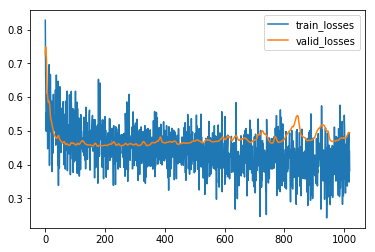

In [8]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='train_losses')
mplot.plot(valid_loss, label='valid_losses')
mplot.legend()
mplot.show()

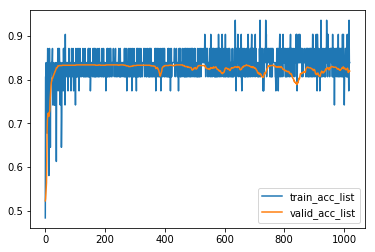

In [9]:
# import matplotlib.pyplot as mplot

mplot.plot(train_acc, label='train_acc_list')
mplot.plot(valid_acc, label='valid_acc_list')
mplot.legend()
mplot.show()